# Delete this after all testing has been done 

## All imports

In [57]:
import jax
# print(jax.__version__)
# installing optax and flax in colab! for optimization
from jax import config
config.update("jax_enable_x64", True)  #double precision


import jax
import jax.numpy as jnp
from jax import grad
from tqdm import trange

import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap
import jax
from jax import jit

from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import Convert_1D2D as convert
import prk_test_method as prk_test


## doing some test to make gradient same on a test_function()

In [38]:
import jax
import jax.numpy as jnp
from jax import jit, lax
import numpy as np

@jit
def One_Dim_Matrix(A):
    dim_x, dim_y = A.shape
    A = A.reshape(1, (dim_x * dim_y))
    return A

@jit
def Add_B_tomatrix_A(A, b):
    A = jnp.append(A, b)
    return A

@jit
def actual_A_1D(A):
    b1 = A[16:20]
    A_new = A[0:16]
    return A_new, b1

@jit
def actual_A1_A2(A):
    A1 = A[0:20]
    A2 = A[20:40]
    return A1, A2

@jit
def One_D_to_TwoD(A):
    A = A.reshape(4, 4)
    return A

@jit
def f(y, z, alpha_values):
    return z

@jit
def g(y, z, alpha_values):
    return -y

@jit
def Energy_Function(y, z, alpha_values):
    return (jnp.square(y) + jnp.square(z)) / 2

@jit
def PRK_step(y0, z0, h, A1, A2, B1, B2, alpha_values):
    s = A1.shape[0]
    dim = jnp.size(y0)
    tol = 1e-10
    K_old = jnp.zeros((s, dim))
    L_old = jnp.zeros((s, dim))
    K_new = f(y0 + h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
    L_new = g(y0 + h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
    init_state = 0, K_new, L_new, K_old, L_old, alpha_values

    def body_while_loop(state):
        _, K_new, L_new, K_old, L_old, alpha_values = state
        K_old = K_new
        L_old = L_new
        K_new = f(y0 + h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
        L_new = g(y0 + h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
        return _, K_new, L_new, K_old, L_old, alpha_values

    def condition_while_loop(state):
        _, K_new, L_new, K_old, L_old, alpha_values = state
        norms = jnp.sum(jnp.array([jnp.linalg.norm(K_new - K_old) + jnp.linalg.norm(L_new - L_old)]))
        return norms > tol

    _, K_new, L_new, K_old, L_old, alpha_values = lax.while_loop(condition_while_loop, body_while_loop, init_state)
    yn = y0 + h * jnp.sum(jnp.multiply(B1, K_new))
    zn = z0 + h * jnp.sum(jnp.multiply(B2, L_new))
    return yn, zn

@jit
def fori_loop_1(i, state):
    yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep = state
    y, z = PRK_step(y, z, h, A1, A2, B1, B2, alpha_values)
    yn_list = yn_list.at[i].set(y.ravel())
    zn_list = zn_list.at[i].set(z.ravel())
    return yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep

@jit
def fori_loop_2(j, state):
    iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values, h, istep = state
    iy, iz = PRK_step(iy, iz, h/istep, A1, A2, B1, B2, alpha_values)
    iyn_list = iyn_list.at[j].set(iy.ravel())
    izn_list = izn_list.at[j].set(iz.ravel())
    return iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values, h, istep

def huber_loss(x, delta=1.0):
    return jnp.where(jnp.abs(x) <= delta, 0.5 * jnp.square(x), delta * (jnp.abs(x) - 0.5 * delta))


def find_error_test(A1D, H_sequence):
    """remove all these lines

     ##  definig to check the grandient
    
    """
    # print("The name is Pandey, Ravi Pandey")
    # H_sequence = [-1, -1, -1, -1, -1, -1]

    time_factor = 1
    a1, a2 = actual_A1_A2(A1D)
    a1, B1 = actual_A_1D(a1)
    A1 = One_D_to_TwoD(a1)
    a2, B2 = actual_A_1D(a2)
    A2 = One_D_to_TwoD(a2)
    
    final_error = 0 ##  definig to check the grandien

    B1 = jnp.reshape(B1, (4, 1))
    B2 = jnp.reshape(B2, (4, 1))

    alpha_values = jnp.reshape(jnp.array(H_sequence[:4]), (1, 4))

    y0 = jnp.reshape(jnp.array(H_sequence[4]), (1, 1))
    z0 = jnp.reshape(jnp.array(H_sequence[5]), (1, 1))

    istep = 10
    NN = jnp.array([100])

    yn_list = jnp.zeros((time_factor * NN[0], 1))
    zn_list = jnp.zeros((time_factor * NN[0], 1))
    iyn_list = jnp.zeros((time_factor * istep * NN[0], 1))
    izn_list = jnp.zeros((time_factor * istep * NN[0], 1))

    h = time_factor / NN[0]
    y = y0
    z = z0
    
    init_state_yz = yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep
    yn_list, zn_list, _, _, _, _, _, _, _, _, _ = lax.fori_loop(0, time_factor * NN[0], fori_loop_1, init_state_yz)

    
    H = Energy_Function(yn_list, zn_list, alpha_values)
    energy_error = jnp.sum(jnp.square(H - H[0])) / len(H)

    init_state_iyz = iyn_list, izn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep
    iyn_list, izn_list, _, _, _, _, _, _, _, _, _ = lax.fori_loop(0, time_factor * istep * NN[0], fori_loop_2, init_state_iyz)
    
    ## Gradient using jacfwd works till here correctly 

    j1_iyn_list = iyn_list[9:istep * NN[0]:10]
    j2_izn_list = izn_list[9:istep * NN[0]:10]
    

    err1 = j1_iyn_list.ravel() - yn_list.ravel()
    err2 = j2_izn_list.ravel() - zn_list.ravel()
    
    
    final_error = (jnp.sum(jnp.abs(err1)) + jnp.sum(jnp.abs(err2))) / (2 * NN[0])    ### am i sure it will be divided by 2 ? cross check it again.
    
    #final_error = (jnp.sum(huber_loss(err1)) + jnp.sum(huber_loss(err2))) / (2 * NN[0])

    return jnp.sum(final_error)

    

    return jnp.sum(final_error) # + energy_error


In [16]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np

# Simplified test function
def test_function(x):
    # return jnp.abs(jnp.sum(x**2))
    return find_error_test(x)

# Initial test input

A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
x = convert.Convert_toOneD(A1, A2, B1, B2)
# x = jnp.array([1.0, 2.0, 3.0, 4.0])

# Compute gradients using jax.jacfwd
grad_fn = jacfwd(test_function)
jax_gradients = grad_fn(x)

# Finite difference gradient checking
epsilon = 1e-5
numerical_gradients = np.zeros_like(x)

for i in range(len(x)):
    x_plus = x.at[i].set(x[i] + epsilon)
    x_minus = x.at[i].set(x[i] - epsilon)
    numerical_gradients[i] = (test_function(x_plus) - test_function(x_minus)) / (2 * epsilon)

# Compare gradients
print("Gradient check with simplified function:")
print("JAX Gradients:", jax_gradients)
print("Numerical Gradients:", numerical_gradients)
print("Difference:", jax_gradients - numerical_gradients)
print("Max difference:", np.max(np.abs(jax_gradients - numerical_gradients)))

# You can set a tolerance for acceptable difference
tolerance = 1e-4
if np.allclose(jax_gradients, numerical_gradients, atol=tolerance):
    print("Gradients are correct within tolerance.")
else:
    print("Gradients are incorrect.")


Gradient check with simplified function:
JAX Gradients: [-2.31448169e-15 -2.28354869e-15 -2.25255231e-15 -2.31448169e-15
 -9.28915147e-15 -9.16516540e-15 -9.04092501e-15 -9.28915147e-15
 -2.33009405e-15 -2.29903401e-15 -2.26791020e-15 -2.33009405e-15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.35795117e-16  6.90877386e-15  1.37047895e-14  1.35795117e-16
  2.31574921e-15  2.32358762e-15  2.33136163e-15  2.31574921e-15
  9.13913900e-15  9.17023675e-15  9.20108002e-15  9.13913900e-15
  2.25382029e-15  2.26153075e-15  2.26917838e-15  2.25382029e-15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.92235914e-17 -6.85442047e-15 -1.37047895e-14  8.92235914e-17]
Numerical Gradients: [-2.31442043e-15 -2.28357232e-15 -2.25274135e-15 -2.31442043e-15
 -9.28966636e-15 -9.16581639e-15 -9.04068226e-15 -9.28966636e-15
 -2.33027815e-15 -2.29926949e-15 -2.26777912e-15 -2.33027815e-15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.99540798

100%|██████████| 1000/1000 [00:02<00:00, 391.92it/s]


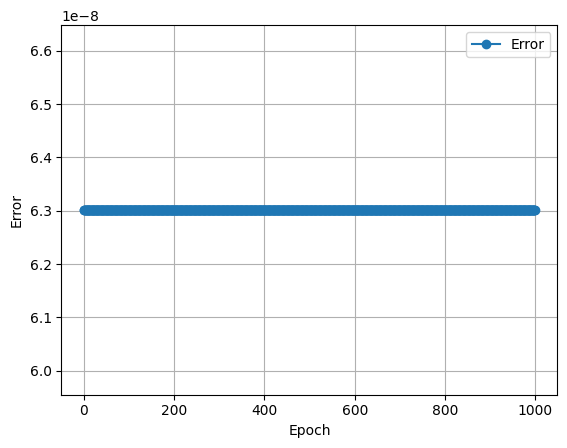

Final A1D shape: (40,)


In [53]:
def numerical_gradient(A1D, epsilon=1e-5):
    numerical_gradients = np.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus) - compute_error(A1D_minus)) / (2 * epsilon)

    return numerical_gradients

# Compute numerical gradients
numerical_gradients = numerical_gradient(x)

# Training loop
error_list = []
learning_rate = 0.001

for epoch in trange(1000):
    # Compute the gradient for the current parameters using the numerical method
    gradients = numerical_gradients #numerical_gradient(A1D)
    
    # Update the parameters using gradient descent
    A1D = A1D - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(x)
    
    # Store the error for plotting
    error_list.append(current_error)

# Plot the error
error_list = jnp.array(error_list)
plt.plot(range(len(error_list)), error_list, label="Error", marker='o')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# Print final shape of A1D
print("Final A1D shape:", A1D.shape)

## checking the numerica gradient method :

Initial A1D shape: (40,)


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


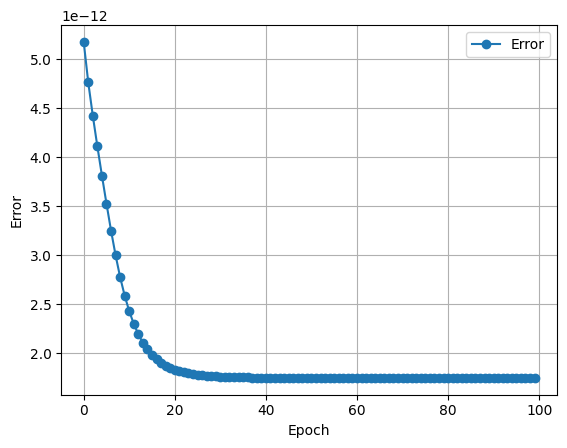

Final A1D shape: (40,)


In [5]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Assuming the necessary functions like find_error, convert.Convert_toOneD, etc., are defined

# Define the A and B matrices
A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)
print("Initial A1D shape:", A1D.shape)

# Function to compute error
def compute_error(A1D):
    return find_error(A1D)

# Finite difference gradient checking
epsilon = 1e-5

def compute_numerical_gradient(A1D):
    numerical_gradients = np.zeros_like(A1D)
    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus) - compute_error(A1D_minus)) / (2 * epsilon)
    return numerical_gradients

# Training loop using numerical gradients
error_list = []
learning_rate = 0.0001

for epoch in trange(100):
    # Compute the numerical gradient for the current parameters
    gradients = compute_numerical_gradient(A1D)
    
    # Update the parameters using gradient descent
    A1D = A1D - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D)
    
    # Store the error for plotting
    error_list.append(current_error)

# Plot the error
error_list = jnp.array(error_list)
plt.plot(range(len(error_list)), error_list, label="Error", marker='o')
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# Print final shape of A1D
print("Final A1D shape:", A1D.shape)


Initial A1D shape: (40,)


Numerical Gradients: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


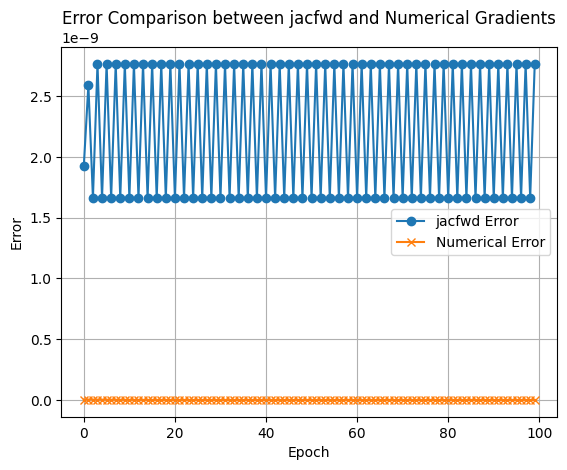

In [7]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Assuming the necessary functions like find_error, convert.Convert_toOneD, etc., are defined

# Define the A and B matrices
A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
A1D_initial = convert.Convert_toOneD(A1, A2, B1, B2)
print("Initial A1D shape:", A1D_initial.shape)

# Function to compute error
def compute_error(A1D):
    return find_error(A1D)

# Finite difference gradient checking
epsilon = 1e-5

def compute_numerical_gradient(A1D):
    numerical_gradients = np.zeros_like(A1D)
    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus) - compute_error(A1D_minus)) / (2 * epsilon)
    return numerical_gradients

# Gradient function using jax.jacfwd
grad_fn = jacfwd(compute_error)

# Training loop for jax.jacfwd gradients
error_list_jacfwd = []
A1D = A1D_initial.copy()
learning_rate = 0.0001  # Adjusted learning rate

for epoch in trange(100, desc="jax.jacfwd"):
    # Compute the gradient for the current parameters using jax.jacfwd
    gradients = grad_fn(A1D)
    
    # Update the parameters using gradient descent
    A1D = A1D - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D)
    
    # Store the error for plotting
    error_list_jacfwd.append(current_error)

# Training loop for numerical gradients
error_list_numerical = []
A1D = A1D_initial.copy()

for epoch in trange(100, desc="Numerical Gradients"):
    # Compute the numerical gradient for the current parameters
    gradients = compute_numerical_gradient(A1D)
    
    # Update the parameters using gradient descent
    A1D = A1D - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D)
    
    # Store the error for plotting
    error_list_numerical.append(current_error)

# Plotting both error curves
plt.plot(range(len(error_list_jacfwd)), error_list_jacfwd, label="jacfwd Error", marker='o')
plt.plot(range(len(error_list_numerical)), error_list_numerical, label="Numerical Error", marker='x')
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error Comparison between jacfwd and Numerical Gradients')
plt.show()


Initial A1D shape: (40,)


Numerical Gradients: 100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


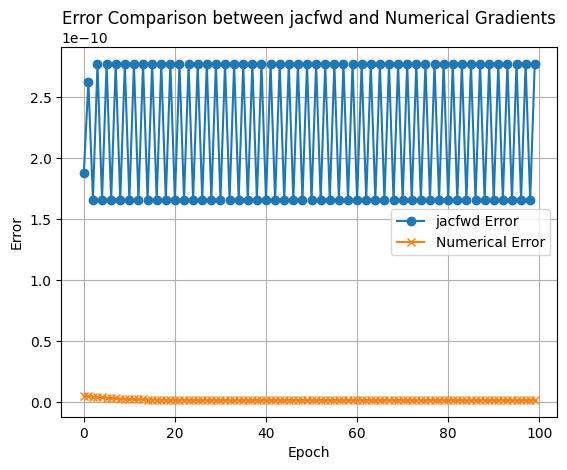

In [8]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Assuming the necessary functions like find_error, convert.Convert_toOneD, etc., are defined

# Define the A and B matrices
A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
A1D_initial = convert.Convert_toOneD(A1, A2, B1, B2)
print("Initial A1D shape:", A1D_initial.shape)

# Function to compute error
def compute_error(A1D):
    return find_error(A1D)

# Finite difference gradient checking
epsilon = 1e-5

def compute_numerical_gradient(A1D):
    numerical_gradients = np.zeros_like(A1D)
    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus) - compute_error(A1D_minus)) / (2 * epsilon)
    return numerical_gradients

# Gradient function using jax.jacfwd
grad_fn = jacfwd(compute_error)

# Training loop for jax.jacfwd gradients
error_list_jacfwd = []
A1D = A1D_initial.copy()
learning_rate_jacfwd = 0.00001  # Further reduced learning rate

for epoch in trange(100, desc="jax.jacfwd"):
    # Compute the gradient for the current parameters using jax.jacfwd
    gradients = grad_fn(A1D)
    
    # Update the parameters using gradient descent
    A1D = A1D - learning_rate_jacfwd * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D)
    
    # Store the error for plotting
    error_list_jacfwd.append(current_error)

# Training loop for numerical gradients
error_list_numerical = []
A1D = A1D_initial.copy()
learning_rate_numerical = 0.0001  # Same learning rate as before

for epoch in trange(100, desc="Numerical Gradients"):
    # Compute the numerical gradient for the current parameters
    gradients = compute_numerical_gradient(A1D)
    
    # Update the parameters using gradient descent
    A1D = A1D - learning_rate_numerical * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D)
    
    # Store the error for plotting
    error_list_numerical.append(current_error)

# Plotting both error curves
plt.plot(range(len(error_list_jacfwd)), error_list_jacfwd, label="jacfwd Error", marker='o')
plt.plot(range(len(error_list_numerical)), error_list_numerical, label="Numerical Error", marker='x')
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error Comparison between jacfwd and Numerical Gradients')
plt.show()


## making a demo function find_error() to check jacfwd and numeric gradient 

______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

## Comparing both the gradients , generated using jacfwd() and using numeric method

In [41]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt


H_sequence = [-1, -1, -1, -1, -1, -1]

# Define the A and B matrices
A1 = A2 = jnp.array([
    [0., 0., 0., 0.],
    [5/24, 1/3, -1/24, 0.],
    [1/6, 2/3, 1/6, 0.],
    [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
A1D_initial = convert.Convert_toOneD(A1, A2, B1, B2)
print("Initial A1D shape:", A1D_initial.shape)

# Function to compute error
def compute_error(A1D, H_sequence):
    return find_error_test(A1D, H_sequence)

# Finite difference gradient calculation
def numerical_gradient(A1D, H_sequence, epsilon=1e-5):
    numerical_gradients = np.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus, H_sequence) - compute_error(A1D_minus, H_sequence)) / (2 * epsilon)

    return numerical_gradients

# Gradient function using jax.jacfwd
grad_fn = jacfwd(compute_error)

# Compute gradients using jax.jacfwd
jax_gradients = grad_fn(A1D_initial, H_sequence)

# Compute numerical gradients
numerical_gradients = numerical_gradient(A1D_initial, H_sequence)

# Compare gradients
print("Gradient check:")
print("JAX Gradients:", jax_gradients)
print("Numerical Gradients:", numerical_gradients)
print("Difference:", jax_gradients - numerical_gradients)
print("Max difference:", np.max(np.abs(jax_gradients - numerical_gradients)))

# Set a tolerance for acceptable difference
tolerance = 1e-4
if np.allclose(jax_gradients, numerical_gradients, atol=tolerance):
    print("Gradients are correct within tolerance.")
else:
    print("Gradients are incorrect.")

# Training loop using JAX gradients
error_list_jax = []
A1D_jax = A1D_initial.copy()
learning_rate = 0.001  # You can adjust this as needed

for epoch in trange(10, desc="Training with JAX gradients"):
    # Compute the gradient for the current parameters using jax.jacfwd
    gradients = grad_fn(A1D_jax, H_sequence)
    
    # Update the parameters using gradient descent
    A1D_jax = A1D_jax - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D_jax, H_sequence)
    
    # Store the error for plotting
    error_list_jax.append(current_error)

# Training loop using numerical gradients
error_list_numerical = []
A1D_numerical = A1D_initial.copy()

for epoch in trange(10, desc="Training with Numerical gradients"):
    # Compute the gradient for the current parameters using the numerical method
    gradients = numerical_gradient(A1D_numerical, H_sequence)
    
    # Debugging statement to print gradients
    print(f"Epoch {epoch}, Numerical Gradients: {gradients}")
    
    # Update the parameters using gradient descent
    A1D_numerical = A1D_numerical - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D_numerical, H_sequence)
    
    # Debugging statement to print error
    print(f"Epoch {epoch}, Error (Numerical): {current_error}")
    
    # Store the error for plotting
    error_list_numerical.append(current_error)

# Plot the errors
# plt.plot(range(len(error_list_jax)), error_list_jax, label="Error (JAX)", marker='o')
plt.plot(range(len(error_list_numerical)), error_list_numerical, label="Error (Numerical)", marker='x')
# plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# Print final shapes of A1D
print("Final A1D shape (JAX):", A1D_jax.shape)
print("Final A1D shape (Numerical):", A1D_numerical.shape)


Initial A1D shape: (40,)
Gradient check:
JAX Gradients: [-0.00019889 -0.00019647 -0.00019405 -0.00019889 -0.00079962 -0.00078993
 -0.00078023 -0.00079962 -0.00020092 -0.00019849 -0.00019606 -0.00020092
  0.          0.          0.          0.         -0.00012011  0.00059538
  0.00131388 -0.00012011  0.00024283  0.00024385  0.00024486  0.00024283
  0.00096164  0.00096569  0.00096972  0.00096164  0.00023799  0.000239
  0.00024     0.00023799  0.          0.          0.          0.
 -0.00012293 -0.00072205 -0.00131388 -0.00012293]
Numerical Gradients: [-4.24141575e-07 -4.24153482e-07 -4.24183172e-07 -4.24141575e-07
 -4.24147058e-07 -4.24162509e-07 -4.24092234e-07 -4.24147058e-07
 -4.24280540e-07 -4.24264952e-07 -4.24173691e-07 -4.24280540e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.00471465e-08  4.25026256e-07  5.32078549e-07  6.00427587e-08
  5.33849629e-07  5.33998410e-07  5.33949111e-07  5.33849629e-07
  5.34001408e-07  5.33860755e-07  5.33916878e-07  5.340

Training with Numerical gradients:  10%|█         | 1/10 [00:00<00:02,  3.83it/s]

Epoch 0, Numerical Gradients: [-4.24141575e-07 -4.24153482e-07 -4.24183172e-07 -4.24141575e-07
 -4.24147058e-07 -4.24162509e-07 -4.24092234e-07 -4.24147058e-07
 -4.24280540e-07 -4.24264952e-07 -4.24173691e-07 -4.24280540e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.00471465e-08  4.25026256e-07  5.32078549e-07  6.00427587e-08
  5.33849629e-07  5.33998410e-07  5.33949111e-07  5.33849629e-07
  5.34001408e-07  5.33860755e-07  5.33916878e-07  5.34001408e-07
  5.33828845e-07  5.33807663e-07  5.33810236e-07  5.33828845e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.86575244e-08 -5.32057275e-07 -5.35646839e-07  3.86575032e-08]
Epoch 0, Error (Numerical): 6.294650933304224e-12


Training with Numerical gradients:  20%|██        | 2/10 [00:00<00:02,  3.90it/s]

Epoch 1, Numerical Gradients: [-4.74690114e-07 -4.74748293e-07 -4.74724151e-07 -4.74690114e-07
 -4.74792775e-07 -4.74728801e-07 -4.74829932e-07 -4.74792775e-07
 -4.74618948e-07 -4.74728184e-07 -4.74627667e-07 -4.74618948e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.12483970e-07  4.75628196e-07 -6.31330315e-07  5.12485072e-07
 -6.29480103e-07 -6.29488389e-07 -6.29437208e-07 -6.29480103e-07
 -6.29532465e-07 -6.29519712e-07 -6.29603989e-07 -6.29532465e-07
 -6.29373270e-07 -6.29304948e-07 -6.29374954e-07 -6.29373270e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.07490469e-07  6.31287247e-07  6.27771132e-07  5.07489324e-07]
Epoch 1, Error (Numerical): 9.787480843154173e-12


Training with Numerical gradients:  30%|███       | 3/10 [00:00<00:01,  3.74it/s]

Epoch 2, Numerical Gradients: [ 7.41443025e-07  7.41493006e-07  7.41438202e-07  7.41443025e-07
  7.41401641e-07  7.41493185e-07  7.41475959e-07  7.41401641e-07
  7.41285568e-07  7.41307931e-07  7.41228155e-07  7.41285568e-07
 -5.18682319e-13 -5.18682319e-13 -5.18682319e-13 -5.18682319e-13
 -9.45417191e-07 -7.40531870e-07  7.37128523e-07 -9.45414568e-07
  7.39027581e-07  7.38938991e-07  7.38956562e-07  7.39027581e-07
  7.38827911e-07  7.38926894e-07  7.38802748e-07  7.38827911e-07
  7.39133028e-07  7.39162125e-07  7.39073727e-07  7.39133028e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.56614432e-07 -7.37085379e-07 -7.40719762e-07 -9.56613693e-07]
Epoch 2, Error (Numerical): 1.1195599005156542e-11


KeyboardInterrupt: 

# Trying on 24th June

Initial A1D shape: (40,)
Gradient check:
JAX Gradients: [-0.00019889 -0.00019647 -0.00019405 -0.00019889 -0.00079962 -0.00078993
 -0.00078023 -0.00079962 -0.00020092 -0.00019849 -0.00019606 -0.00020092
  0.          0.          0.          0.         -0.00012011  0.00059538
  0.00131388 -0.00012011  0.00024283  0.00024385  0.00024486  0.00024283
  0.00096164  0.00096569  0.00096972  0.00096164  0.00023799  0.000239
  0.00024     0.00023799  0.          0.          0.          0.
 -0.00012293 -0.00072205 -0.00131388 -0.00012293]
Numerical Gradients: [-4.24141575e-07 -4.24153482e-07 -4.24183172e-07 -4.24141575e-07
 -4.24147058e-07 -4.24162509e-07 -4.24092234e-07 -4.24147058e-07
 -4.24280540e-07 -4.24264952e-07 -4.24173691e-07 -4.24280540e-07
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.00471465e-08  4.25026256e-07  5.32078549e-07  6.00427587e-08
  5.33849629e-07  5.33998410e-07  5.33949111e-07  5.33849629e-07
  5.34001408e-07  5.33860755e-07  5.33916878e-07  5.340

Training with Numerical gradients: 100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


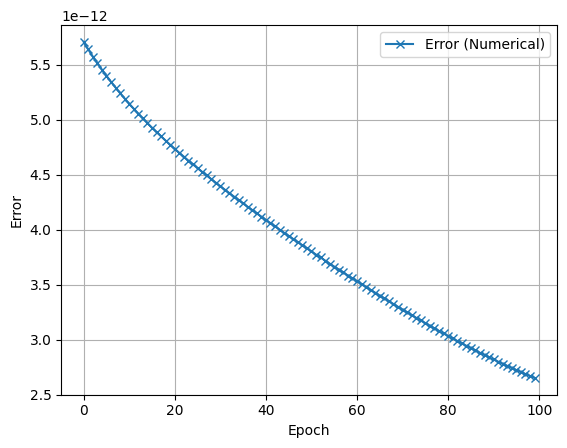

Final A1D shape (JAX): (40,)
Final A1D shape (Numerical): (40,)


In [56]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt


H_sequence = [-1, -1, -1, -1, -1, -1]

# Define the A and B matrices

A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

######## Perturbed :

# A1 = A2 = jnp.array([
#      [1., 2., 0., 0.],
#      [5/24, 4/3, -7/24, 0.],
#      [1/6, 2/3, 1/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
A1D_initial = convert.Convert_toOneD(A1, A2, B1, B2)
print("Initial A1D shape:", A1D_initial.shape)

# Function to compute error
def compute_error(A1D, H_sequence):
    return find_error_test(A1D, H_sequence)

# Finite difference gradient calculation
def numerical_gradient(A1D, H_sequence, epsilon=1e-5):
    numerical_gradients = np.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus, H_sequence) - compute_error(A1D_minus, H_sequence)) / (2 * epsilon)

    return numerical_gradients

# Gradient function using jax.jacfwd
grad_fn = jacfwd(compute_error)

# Compute gradients using jax.jacfwd
jax_gradients = grad_fn(A1D_initial, H_sequence)

# Compute numerical gradients
numerical_gradients = numerical_gradient(A1D_initial, H_sequence)

# Compare gradients
print("Gradient check:")
print("JAX Gradients:", jax_gradients)
print("Numerical Gradients:", numerical_gradients)
print("Difference:", jax_gradients - numerical_gradients)
print("Max difference:", np.max(np.abs(jax_gradients - numerical_gradients)))

# Set a tolerance for acceptable difference
tolerance = 1e-4
if np.allclose(jax_gradients, numerical_gradients, atol=tolerance):
    print("Gradients are correct within tolerance.")
else:
    print("Gradients are incorrect.")

# Training loop using JAX gradients
error_list_jax = []
A1D_jax = A1D_initial.copy()
learning_rate = 0.00001 ## 0.0001 is a good learning rate to analyze the performance , just noticed it

# for epoch in trange(100, desc="Training with JAX gradients"):
#     # Compute the gradient for the current parameters using jax.jacfwd
#     gradients = grad_fn(A1D_jax, H_sequence)
    
#     # Update the parameters using gradient descent
#     A1D_jax = A1D_jax - learning_rate * gradients
    
#     # Compute the error for the current parameters
#     current_error = compute_error(A1D_jax, H_sequence)
    
#     # Store the error for plotting
#     error_list_jax.append(current_error)

# Training loop using numerical gradients
error_list_numerical = []
A1D_numerical = A1D_initial.copy()

for epoch in trange(1000, desc="Training with Numerical gradients"):
    # Compute the gradient for the current parameters using the numerical method
    gradients = numerical_gradient(A1D_numerical, H_sequence)
    
    # Update the parameters using gradient descent
    A1D_numerical = A1D_numerical - learning_rate * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D_numerical, H_sequence)
    
    # Store the error for plotting
    error_list_numerical.append(current_error)

# Plot the errors
# plt.plot(range(len(error_list_jax)), error_list_jax, label="Error (JAX)", marker='o')
plt.plot(range(len(error_list_numerical)), error_list_numerical, label="Error (Numerical)", marker='x')
# plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# Print final shapes of A1D
print("Final A1D shape (JAX):", A1D_jax.shape)
print("Final A1D shape (Numerical):", A1D_numerical.shape)


Initial A1D shape: (40,)


Numerical Gradients: 100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


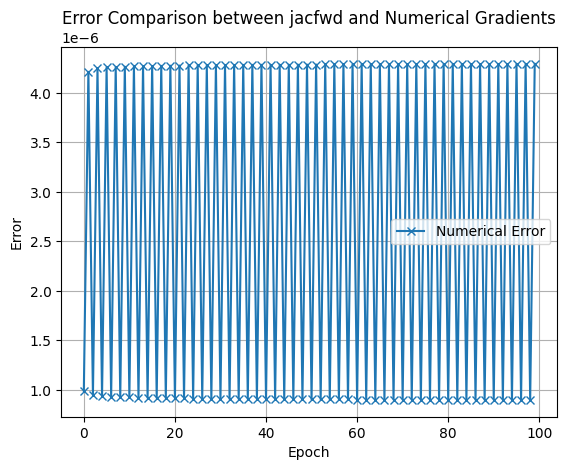

Final A1D shape using jacfwd: (40,)
[[ 0.          0.          0.          0.        ]
 [ 0.20833333  0.33333333 -0.04166667  0.        ]
 [ 0.16666667  0.66666667  0.16666667  0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 0.          0.          0.          0.        ]
 [ 0.20833333  0.33333333 -0.04166667  0.        ]
 [ 0.16666667  0.66666667  0.16666667  0.        ]
 [ 0.          0.          0.          0.        ]]


In [6]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Assuming the necessary functions like find_error_test, convert.Convert_toOneD, etc., are defined

# # Perturbed the A and B matrices
# A1 = A2 = jnp.array([
#      [0., 3., 1., 0.],
#      [5/24, 2/3, -7/24, 0.],
#      [1/6, 2/3, 1/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Define the A and B matrices
A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)
print("Initial A1D shape:", A1D.shape)

# Function to compute error
def compute_error(A1D):
    return prk_test.find_error_test(A1D)

# Gradient function using jax.jacfwd
grad_fn = jacfwd(compute_error)

# Finite difference gradient checking
epsilon = 1e-5

def compute_numerical_gradient(A1D):
    numerical_gradients = np.zeros_like(A1D)
    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus) - compute_error(A1D_minus)) / (2 * epsilon)
    return numerical_gradients

# Training loop for jax.jacfwd gradients
error_list_jacfwd = []
A1D_jacfwd = A1D.copy()
learning_rate_jacfwd = 0.1  # Adjusted learning rate

# Function for gradient clipping
def clip_gradients(gradients, max_norm=1.0):
    norm = jnp.linalg.norm(gradients)
    factor = jnp.minimum(1.0, max_norm / norm)
    return gradients * factor

# for epoch in trange(100, desc="jax.jacfwd"):
#     # Compute the gradient for the current parameters using jax.jacfwd
#     gradients_jacfwd = grad_fn(A1D_jacfwd)
    
#     # Clip the gradients
#     gradients_jacfwd = clip_gradients(gradients_jacfwd)
    
#     # Update the parameters using gradient descent
#     A1D_jacfwd = A1D_jacfwd - learning_rate_jacfwd * gradients_jacfwd
    
#     # Compute the error for the current parameters
#     current_error_jacfwd = compute_error(A1D_jacfwd)
    
#     # Store the error for plotting
#     error_list_jacfwd.append(current_error_jacfwd)

# Training loop for numerical gradients
error_list_numerical = []
A1D_numerical = A1D.copy()
learning_rate_numerical = 0.001  # Same learning rate

for epoch in trange(100, desc="Numerical Gradients"):
    # Compute the numerical gradient for the current parameters
    gradients_numerical = compute_numerical_gradient(A1D_numerical)
    
    # Clip the gradients
    gradients_numerical = clip_gradients(gradients_numerical)
    
    # Update the parameters using gradient descent
    A1D_numerical = A1D_numerical - learning_rate_numerical * gradients_numerical
    
    # Compute the error for the current parameters
    current_error_numerical = compute_error(A1D_numerical)
    
    # Store the error for plotting
    error_list_numerical.append(current_error_numerical)

# Plotting both error curves
# plt.plot(range(len(error_list_jacfwd)), error_list_jacfwd, label="jacfwd Error", marker='o')
plt.plot(range(len(error_list_numerical)), error_list_numerical, label="Numerical Error", marker='x')
# plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error Comparison between jacfwd and Numerical Gradients')
plt.show()

# Print final shape of A1D
print("Final A1D shape using jacfwd:", A1D_jacfwd.shape)
# print("Final A1D shape using numerical gradients:", A1D_numerical.shape)

final_AB = convert.Convert_toTwoD(A1D)
print(A1)
print(final_AB[0])


Error list jacfwd: [Array(0.00075348, dtype=float64), Array(0.00074862, dtype=float64), Array(0.00074379, dtype=float64), Array(0.000739, dtype=float64), Array(0.00073424, dtype=float64), Array(0.00072952, dtype=float64), Array(0.00072483, dtype=float64), Array(0.00072018, dtype=float64), Array(0.00071557, dtype=float64), Array(0.00071098, dtype=float64), Array(0.00070644, dtype=float64), Array(0.00070192, dtype=float64), Array(0.00069744, dtype=float64), Array(0.00069299, dtype=float64), Array(0.00068857, dtype=float64), Array(0.00068419, dtype=float64), Array(0.00067984, dtype=float64), Array(0.00067552, dtype=float64), Array(0.00067124, dtype=float64), Array(0.00066698, dtype=float64), Array(0.00066276, dtype=float64), Array(0.00065856, dtype=float64), Array(0.0006544, dtype=float64), Array(0.00065027, dtype=float64), Array(0.00064617, dtype=float64), Array(0.0006421, dtype=float64), Array(0.00063806, dtype=float64), Array(0.00063404, dtype=float64), Array(0.00063006, dtype=float64)

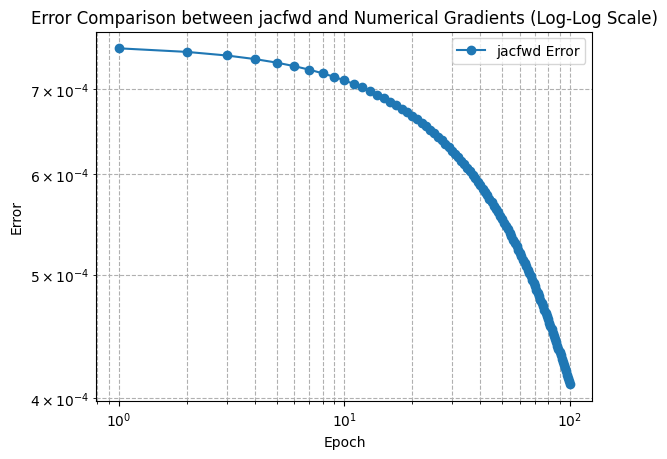

In [7]:
# Debugging step to print the error list
print("Error list jacfwd:", error_list_jacfwd)

# Check if the error list is empty
if len(error_list_jacfwd) == 0:
    print("Error list is empty. Ensure compute_error function and training loop populate it correctly.")
else:
    import numpy as np
    import matplotlib.pyplot as plt

    # Convert error lists to numpy arrays
    error_list_jacfwd_np = np.array(error_list_jacfwd)
    # error_list_numerical_np = np.array(error_list_numerical)

    # Check for non-positive values
    print("Min jacfwd Error:", np.min(error_list_jacfwd_np))
    # print("Min Numerical Error:", np.min(error_list_numerical_np))

    # Ensure that the error lists do not contain zero or negative values
    error_list_jacfwd_np = np.where(error_list_jacfwd_np <= 0, 1e-10, error_list_jacfwd_np)
    # error_list_numerical_np = np.where(error_list_numerical_np <= 0, 1e-10, error_list_numerical_np)

    # Plotting both error curves on a log-log scale
    plt.loglog(range(1, len(error_list_jacfwd_np) + 1), error_list_jacfwd_np, label="jacfwd Error", marker='o')
    # plt.loglog(range(1, len(error_list_numerical_np) + 1), error_list_numerical_np, label="Numerical Error", marker='x')

    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Error Comparison between jacfwd and Numerical Gradients (Log-Log Scale)')
    plt.show()


In [48]:
print(A1D)
print(A1D_jacfwd)
# final_AB = convert.Convert_toTwoD(A1D_jacfwd)
# print(final_AB[0])

[ 0.          3.          1.          0.          0.20833333  0.66666667
 -0.29166667  0.          0.16666667  0.66666667  0.16666667  0.
  0.          0.          0.          0.          0.16666667  0.66666667
  0.16666667  0.          0.          3.          1.          0.
  0.20833333  0.66666667 -0.29166667  0.          0.16666667  0.66666667
  0.16666667  0.          0.          0.          0.          0.
  0.16666667  0.66666667  0.16666667  0.        ]
[ 0.          3.          1.          0.          0.20833333  0.66666667
 -0.29166667  0.          0.16666667  0.66666667  0.16666667  0.
  0.          0.          0.          0.          0.16666667  0.66666667
  0.16666667  0.          0.          3.          1.          0.
  0.20833333  0.66666667 -0.29166667  0.          0.16666667  0.66666667
  0.16666667  0.          0.          0.          0.          0.
  0.16666667  0.66666667  0.16666667  0.        ]


### For live plotting of the above program

Initial A1D shape: (40,)


  0%|          | 0/1000 [00:00<?, ?it/s]

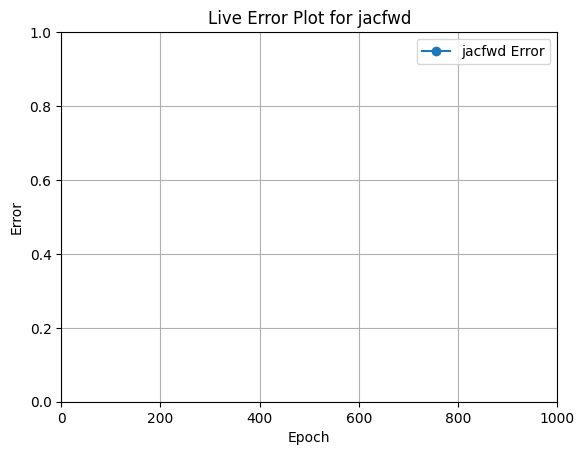

Final A1D shape using jacfwd: (40,)
[[ 0.          3.          1.          0.        ]
 [ 0.20833333  0.66666667 -0.29166667  0.        ]
 [ 0.16666667  0.66666667  0.16666667  0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 0.          3.          1.          0.        ]
 [ 0.20833333  0.66666667 -0.29166667  0.        ]
 [ 0.16666667  0.66666667  0.16666667  0.        ]
 [ 0.          0.          0.          0.        ]]


In [44]:
####  For Live Plot :

import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming the necessary functions like find_error_test, convert.Convert_toOneD, etc., are defined

# Define the A and B matrices
A1 = A2 = jnp.array([
     [0., 3., 1., 0.],
     [5/24, 2/3, -7/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
A1D = convert.Convert_toOneD(A1, A2, B1, B2)
print("Initial A1D shape:", A1D.shape)

# Function to compute error
def compute_error(A1D):
    return find_error_test(A1D)

# Gradient function using jax.jacfwd
grad_fn = jacfwd(compute_error)

# Finite difference gradient checking
epsilon = 1e-5

def compute_numerical_gradient(A1D):
    numerical_gradients = np.zeros_like(A1D)
    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus) - compute_error(A1D_minus)) / (2 * epsilon)
    return numerical_gradients

# Training loop for jax.jacfwd gradients
error_list_jacfwd = []
A1D_jacfwd = A1D.copy()
learning_rate_jacfwd = 0.1  # Adjusted learning rate

# Function for gradient clipping
def clip_gradients(gradients, max_norm=1.0):
    norm = jnp.linalg.norm(gradients)
    factor = jnp.minimum(1.0, max_norm / norm)
    return gradients * factor

# Set up the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], label="jacfwd Error", marker='o')
ax.legend()
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
ax.set_title('Live Error Plot for jacfwd')

# Initialize the plot limits
def init():
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 1)
    return line,

# Update the plot with new data
def update(frame):
    # Compute the gradient for the current parameters using jax.jacfwd
    gradients_jacfwd = grad_fn(A1D_jacfwd)
    
    # Clip the gradients
    gradients_jacfwd = clip_gradients(gradients_jacfwd)
    
    # Update the parameters using gradient descent
    A1D_jacfwd -= learning_rate_jacfwd * gradients_jacfwd
    
    # Compute the error for the current parameters
    current_error_jacfwd = compute_error(A1D_jacfwd)
    
    # Store the error for plotting
    error_list_jacfwd.append(current_error_jacfwd)
    
    # Update the plot data
    line.set_data(range(len(error_list_jacfwd)), error_list_jacfwd)
    ax.set_ylim(0, max(error_list_jacfwd) + 1e-9)
    
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=trange(1000), init_func=init, blit=True, repeat=False)
plt.show()

# Print final shape of A1D
print("Final A1D shape using jacfwd:", A1D_jacfwd.shape)
final_AB = convert.Convert_toTwoD(A1D_jacfwd)
print(A1)
print(final_AB[0])


## Checking if convergence using both numeric and jacfwd method works same or not

Initial A1D shape: (40,)


Numerical Gradients: 100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


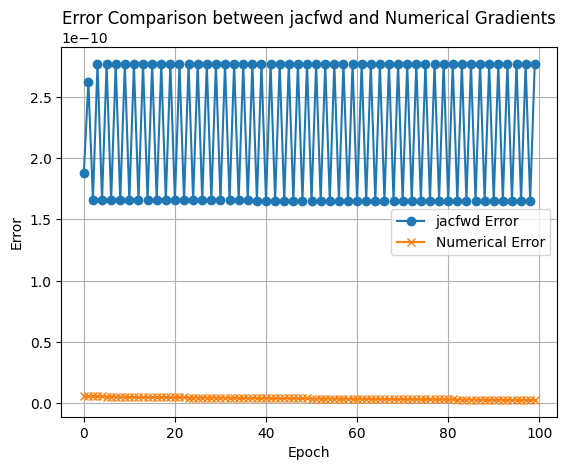

In [55]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Simplified find_error function
# def find_error(A1D):
#     error = jnp.sum((A1D - 1)**2)
#     return error


# Assuming the necessary functions like find_error, convert.Convert_toOneD, etc., are defined

# Define the A and B matrices
A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Initial A1D
A1D_initial = convert.Convert_toOneD(A1, A2, B1, B2)
print("Initial A1D shape:", A1D_initial.shape)

# Function to compute error
def compute_error(A1D):
    return find_error_test(A1D)

# Finite difference gradient checking
epsilon = 1e-5

def compute_numerical_gradient(A1D):
    numerical_gradients = np.zeros_like(A1D)
    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients[i] = (compute_error(A1D_plus) - compute_error(A1D_minus)) / (2 * epsilon)
    return numerical_gradients

# Gradient function using jax.jacfwd
grad_fn = jacfwd(compute_error)

# Training loop for jax.jacfwd gradients
error_list_jacfwd = []
A1D = A1D_initial.copy()
learning_rate_jacfwd = 0.00001  # Further reduced learning rate

for epoch in trange(100, desc="jax.jacfwd"):
    # Compute the gradient for the current parameters using jax.jacfwd
    gradients = grad_fn(A1D)
    
    # Update the parameters using gradient descent
    A1D = A1D - learning_rate_jacfwd * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D)
    
    # Store the error for plotting
    error_list_jacfwd.append(current_error)

# Training loop for numerical gradients
error_list_numerical = []
A1D = A1D_initial.copy()
learning_rate_numerical = 0.00001  # Same learning rate as before

for epoch in trange(100, desc="Numerical Gradients"):
    # Compute the numerical gradient for the current parameters
    gradients = compute_numerical_gradient(A1D)
    
    # Update the parameters using gradient descent
    A1D = A1D - learning_rate_numerical * gradients
    
    # Compute the error for the current parameters
    current_error = compute_error(A1D)
    
    # Store the error for plotting
    error_list_numerical.append(current_error)

# Plotting both error curves
plt.plot(range(len(error_list_jacfwd)), error_list_jacfwd, label="jacfwd Error", marker='o')
plt.plot(range(len(error_list_numerical)), error_list_numerical, label="Numerical Error", marker='x')
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error Comparison between jacfwd and Numerical Gradients')
plt.show()


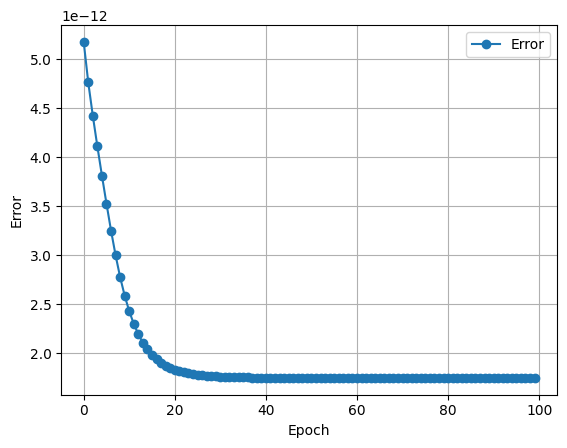

(40,)


In [11]:
# Plot the error
error_list = jnp.array(error_list)
plt.plot(range(len(error_list)), error_list, label="Error", marker='o')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

# Print final shape of A1D
print(A1D.shape)

[Array(5.32469274e-06, dtype=float64), Array(5.19421685e-06, dtype=float64), Array(5.19143036e-06, dtype=float64), Array(5.18990602e-06, dtype=float64), Array(5.18990591e-06, dtype=float64), Array(5.1899058e-06, dtype=float64), Array(5.18990569e-06, dtype=float64), Array(5.18990558e-06, dtype=float64), Array(5.18990547e-06, dtype=float64), Array(5.18990536e-06, dtype=float64), Array(5.18990525e-06, dtype=float64), Array(5.18990514e-06, dtype=float64), Array(5.18990502e-06, dtype=float64), Array(5.18990491e-06, dtype=float64), Array(5.18990481e-06, dtype=float64), Array(5.1899047e-06, dtype=float64), Array(5.18990458e-06, dtype=float64), Array(5.18990447e-06, dtype=float64), Array(5.18990436e-06, dtype=float64), Array(5.18990425e-06, dtype=float64), Array(5.18990414e-06, dtype=float64), Array(5.18990403e-06, dtype=float64), Array(5.18990392e-06, dtype=float64), Array(5.18990382e-06, dtype=float64), Array(5.1899037e-06, dtype=float64), Array(5.18990359e-06, dtype=float64), Array(5.189903

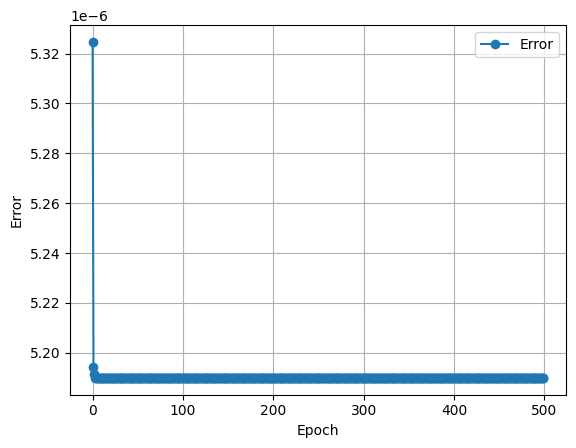

In [55]:

import matplotlib.ticker as ticker

B = []

# Iterate over the list error_list in steps of 2
for i in range(0, len(error_list), 2):
    # Sum pairs of elements and append to list B
    B.append(error_list[i] + error_list[i+1])

# Print the result
print(B)

plt.plot(range(len(B)), B, label="Error", marker='o')

plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

## Testing for convergence :

Note : Read this 

The convergence shows correct result, that means our RK4 method converges correctly. 
Now my main focus is to check why is the plot not showing results properly. 

So i can delete this below program after the testing work is completed. 


In [8]:
import jax
import jax.numpy as jnp
from jax import jit, lax
import numpy as np

@jit
def One_Dim_Matrix(A):
    dim_x, dim_y = A.shape
    A = A.reshape(1, (dim_x * dim_y))
    return A

@jit
def Add_B_tomatrix_A(A, b):
    A = jnp.append(A, b)
    return A

@jit
def actual_A_1D(A):
    b1 = A[16:20]
    A_new = A[0:16]
    return A_new, b1

@jit
def actual_A1_A2(A):
    A1 = A[0:20]
    A2 = A[20:40]
    return A1, A2

@jit
def One_D_to_TwoD(A):
    A = A.reshape(4, 4)
    return A

@jit
def f(y, z, alpha_values):
    return z

@jit
def g(y, z, alpha_values):
    return -y

@jit
def Energy_Function(y, z, alpha_values):
    return (jnp.square(y) + jnp.square(z)) / 2

@jit
def PRK_step(y0, z0, h, A1, A2, B1, B2, alpha_values):
    s = A1.shape[0]
    dim = jnp.size(y0)
    tol = 1e-10
    K_old = jnp.zeros((s, dim))
    L_old = jnp.zeros((s, dim))
    K_new = f(y0 + h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
    L_new = g(y0 + h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
    init_state = 0, K_new, L_new, K_old, L_old, alpha_values

    def body_while_loop(state):
        _, K_new, L_new, K_old, L_old, alpha_values = state
        K_old = K_new
        L_old = L_new
        K_new = f(y0 + h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
        L_new = g(y0 + h * A1 @ K_old, z0 + h * A2 @ L_old, alpha_values)
        return _, K_new, L_new, K_old, L_old, alpha_values

    def condition_while_loop(state):
        _, K_new, L_new, K_old, L_old, alpha_values = state
        norms = jnp.sum(jnp.array([jnp.linalg.norm(K_new - K_old) + jnp.linalg.norm(L_new - L_old)]))
        return norms > tol

    _, K_new, L_new, K_old, L_old, alpha_values = lax.while_loop(condition_while_loop, body_while_loop, init_state)
    yn = y0 + h * jnp.sum(jnp.multiply(B1, K_new))
    zn = z0 + h * jnp.sum(jnp.multiply(B2, L_new))
    return yn, zn

@jit
def fori_loop_1(i, state):
    yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep = state
    y, z = PRK_step(y, z, h, A1, A2, B1, B2, alpha_values)
    yn_list = yn_list.at[i].set(y.ravel())
    zn_list = zn_list.at[i].set(z.ravel())
    return yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep

@jit
def fori_loop_2(j, state):
    iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values, h, istep = state
    iy, iz = PRK_step(iy, iz, h/istep, A1, A2, B1, B2, alpha_values)
    iyn_list = iyn_list.at[j].set(iy.ravel())
    izn_list = izn_list.at[j].set(iz.ravel())
    return iyn_list, izn_list, iy, iz, A1, A2, B1, B2, alpha_values, h, istep

def huber_loss(x, delta=1.0):
    return jnp.where(jnp.abs(x) <= delta, 0.5 * jnp.square(x), delta * (jnp.abs(x) - 0.5 * delta))


def find_error_test(A1D, sss):
    """remove all these lines

     ##  definig to check the grandient
    
    """
    # print("The name is Pandey, Ravi Pandey")
    H_sequence = [-1, -1, -1, -1, -1, -1]

    time_factor = 1
    a1, a2 = actual_A1_A2(A1D)
    a1, B1 = actual_A_1D(a1)
    A1 = One_D_to_TwoD(a1)
    a2, B2 = actual_A_1D(a2)
    A2 = One_D_to_TwoD(a2)
    
    final_error = 0 ##  definig to check the grandien

    B1 = jnp.reshape(B1, (4, 1))
    B2 = jnp.reshape(B2, (4, 1))

    alpha_values = jnp.reshape(jnp.array(H_sequence[:4]), (1, 4))

    y0 = jnp.reshape(jnp.array(H_sequence[4]), (1, 1))
    z0 = jnp.reshape(jnp.array(H_sequence[5]), (1, 1))

    istep = 10
    NN = jnp.array([sss])

    yn_list = jnp.zeros((time_factor * NN[0], 1))
    zn_list = jnp.zeros((time_factor * NN[0], 1))
    iyn_list = jnp.zeros((time_factor * istep * NN[0], 1))
    izn_list = jnp.zeros((time_factor * istep * NN[0], 1))

    h = time_factor / NN[0]
    y = y0
    z = z0
    
    init_state_yz = yn_list, zn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep
    yn_list, zn_list, _, _, _, _, _, _, _, _, _ = lax.fori_loop(0, time_factor * NN[0], fori_loop_1, init_state_yz)

    
    H = Energy_Function(yn_list, zn_list, alpha_values)
    energy_error = jnp.sum(jnp.square(H - H[0])) / len(H)

    init_state_iyz = iyn_list, izn_list, y, z, A1, A2, B1, B2, alpha_values, h, istep
    iyn_list, izn_list, _, _, _, _, _, _, _, _, _ = lax.fori_loop(0, time_factor * istep * NN[0], fori_loop_2, init_state_iyz)
    
    ## Gradient using jacfwd works till here correctly 

    j1_iyn_list = iyn_list[9:istep * NN[0]:10]
    j2_izn_list = izn_list[9:istep * NN[0]:10]
    

    err1 = j1_iyn_list.ravel() - yn_list.ravel()
    err2 = j2_izn_list.ravel() - zn_list.ravel()
    

    final_error = (jnp.sum(jnp.abs(err1)) + jnp.sum(jnp.abs(err2))) / (2 * NN[0])
    
    # final_error = (jnp.sum(huber_loss(err1)) + jnp.sum(huber_loss(err2))) / (2 * NN[0])


    return jnp.sum(final_error)

    return jnp.sum(final_error) # + energy_error


Text(0, 0.5, 'Log Error')

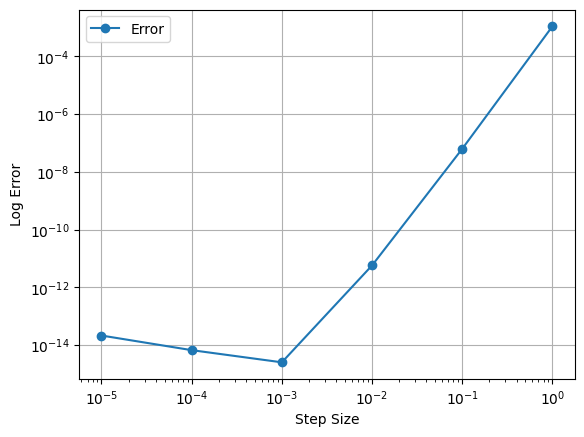

In [11]:
import jax
import jax.numpy as jnp
from jax import jacfwd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Define the A and B matrices
A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

A1D_initial = convert.Convert_toOneD(A1, A2, B1, B2)

step_size_list_convergence = []
error_list_convergence = []

sss = 1 
for i in range(6):
  e1 = find_error_test(A1D, sss)
  step_size_list_convergence.append(1/sss)
  error_list_convergence.append(e1)

  sss *= 10


plt.loglog(step_size_list_convergence, error_list_convergence, label = "Error",marker='o')
# plt.loglog(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')

plt.legend()
plt.grid()
plt.xlabel('Step Size')
plt.ylabel('Log Error')


